In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import folium
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from pyvirtualdisplay import Display
import time
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


In [3]:
browser = webdriver.Firefox()
url = "https://www.komandirovka.ru/sights/kirovograd/"
browser.get(url)
html = browser.find_element_by_tag_name('html')
html.send_keys(Keys.END)
time.sleep(5)
all_hover_elements = browser.find_elements_by_class_name("detail_h")
full_link=[]
for hover_element in all_hover_elements:
        a_element = hover_element.find_element_by_tag_name("a")
        full_link.append(a_element.get_attribute("href"))
browser.quit()


In [4]:
def  get_gps(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html,'html.parser')
    return(soup.find_all(class_="obj_in_it")[2].text.strip())
       
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd;
        
def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return (lat)

def get_name(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html,'html.parser')
    return(soup.title.string)

In [9]:
def convert_lat(str):
    d = re.findall(r'[^"\s]\S*|".+?"', str)
    return(parse_dms(d[1]+d[2]+d[3]))

def convert_long(str):
    d = re.findall(r'[^"\s]\S*|".+?"', str)
    return(parse_dms(d[5]+d[6]+d[7]))

In [6]:
gps = []
for i in range(len(full_link)):
     gps.append(get_gps(full_link[i]))

In [7]:
name = []
for i in range(len(full_link)):
     name.append(get_name(full_link[i]))

In [10]:
df = pd.DataFrame(gps)
df.columns = ['coor']
for i in range(len(gps)):
    df["coor"][i]=re.sub(r'.*N', 'N', df["coor"][i])
df["lat"] = df["coor"].apply(convert_lat)
df["long"] = df["coor"].apply(convert_long)
df["Name of attraction"] = name
df.head(10)

,coor,lat,long,Name of attraction
0,"N 48° 30' 20.4876"" E 32° 15' 6.4296""",48.505556,32.251667,Кировоградский городской литературно-мемориаль...
1,"N 48° 30' 32.4828"" E 32° 16' 5.3652""",48.508889,32.268056,Кировоградский городской музей музыкальной кул...
2,"N 48° 30' 35.7444"" E 32° 16' 8.0112""",48.509722,32.268889,"Кировоградский областной краеведческий музей, ..."
3,"N 48° 30' 21.2148"" E 32° 15' 47.4912""",48.505833,32.263056,Кировоградский областной художественный музей ...
4,"N 48° 30' 23.778"" E 32° 16' 38.604""",48.506389,32.277222,Кировоградский художественно-мемориальный музе...
5,"N 48° 30' 0.5508"" E 32° 16' 17.7132""",48.500000,32.271389,"Мемориальный музей М.Л. Кропивницкого, Кропивн..."
6,"N 48° 30' 32.5296"" E 32° 16' 5.3472""",48.508889,32.268056,"Народный музей Г. Нейгауза, Кропивницкий (Киро..."
7,"N 48° 31' 45.1884"" E 32° 15' 42.21""",48.529167,32.261667,"Храм Успения Пресвятой Богородицы, Кропивницки..."
8,"N 48° 30' 33.6744"" E 32° 16' 7.8564""",48.509167,32.268611,"Галерея Елисаветград, Кропивницкий (Кировоград)"
9,"N 48° 30' 27.378"" E 32° 15' 40.9464""",48.507500,32.261111,Кировоградский академический областной театр к...


In [11]:
from numpy import array
a = array(gps)

gps1 = np.delete(a,(37,39))
from numpy import array
a = array(name)
name1 = np.delete(a,(37,39))

In [12]:
df = pd.DataFrame(gps1)
df.columns = ['coor']
for i in range(len(gps1)):
    df["coor"][i]=re.sub(r'.*N', 'N', df["coor"][i])
df["lat"] = df["coor"].apply(convert_lat)
df["long"] = df["coor"].apply(convert_long)
df["Name of attraction"] = name1

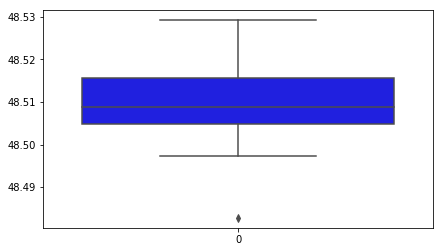

In [13]:
import seaborn as sns
plt.figure(figsize=(7,4))

sns.boxplot(data =df['lat'], color="blue")


In [14]:
df= df[(df.lat > 48.4) & (df.lat < 48.6)]
df = df.reset_index()

In [15]:
X=df[["lat" ,"long"]]
K = 5
kmeans_model = KMeans(n_clusters=K).fit(X)

df["cluster"]= kmeans_model.labels_


In [16]:
df['marker_color'] = pd.cut(df['cluster'], bins=5, labels=['yellow', 'blue', 'red','cyan','magenta'])

In [17]:
map_ = folium.Map(location=[48.5132000, 32.2597000], zoom_start=13)

locs = df[['lat', 'long']]
loc_list = locs.values.tolist()


for point in range(0, len(loc_list)):
    folium.CircleMarker(loc_list[point],fill=True, # Set fill to True
                            fill_color=df['marker_color'][point],fill_opacity=0.7, popup=df['Name of attraction'][point],).add_to(map_)
    
map_